# Combining Precipitation Data from .nc4 Files
This Jupyter Notebook demonstrates how to combine multiple `.nc4` files containing precipitation data into a single file using Python. The process leverages the `xarray` library for data manipulation and `dask` for efficient computation on potentially large datasets. This method assumes that all `.nc4` files to be combined are stored in a specified directory and share a similar structure.

In [33]:
import xarray as xr
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd

## Define the Directory Path
Specify the directory where your `.nc4` files are located.

In [4]:
# Directory where your .nc4 files are stored
directory_path = "Z:/JAX/AORC/AORC_APCP_4KM_LMRFC_201708-09"

## List and Combine Files
List all `.nc4` files in the directory and combine them into a single dataset.

In [5]:

# List all .nc4 files in the directory with a progress bar
nc_files = [os.path.join(directory_path, f) for f in tqdm(os.listdir(directory_path), desc="Listing .nc4 files") if f.endswith('.nc4')]

# Open all files as a single dataset using xarray and dask for lazy loading
combined_ds = xr.open_mfdataset(nc_files, combine='by_coords')

# Save the combined dataset to a new file
output_filename = "combined_precipitation_data.nc4"
combined_ds.to_netcdf(path=output_filename)

print(f"Combined file saved as {output_filename}")


Listing .nc4 files: 100%|██████████████████████████████████████████████████████████████| 1464/1464 [00:00<00:00, 243988.60it/s]
C:\Users\asaharia\AppData\Roaming\Python\Python39\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
C:\tools\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\asaharia\AppData\Roaming\Python\Python39\site-packages\xarray\core\concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Combined file saved as combined_precipitation_data.nc4


## Clip the dataset with a shapefile

In [19]:
import xarray as xr
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping

# Load the .nc4 file
nc_file = "Z:/JAX/AORC/combined_precipitation_data.nc4"
ds = xr.open_dataset(nc_file)

# Load the shapefile
shp_file = "Z:\JAX\Domain_extent\domain_extent_buffered.shp"
geodf = gpd.read_file(shp_file)

# Assuming your dataset's spatial dimensions are latitude and longitude and it uses WGS 84 (EPSG:4326)
# If your dataset uses a different CRS, replace 'EPSG:4326' with the correct EPSG code
ds.rio.write_crs("EPSG:4326", inplace=True)

# Clip the dataset with the shapefile's geometry
clipped_ds = ds.rio.clip(geodf.geometry.apply(mapping), geodf.crs)

# Save the clipped dataset to a new NetCDF file
output_nc_file = "Z:/JAX/AORC/combined_precipitation_data_clipped_new.nc4"
clipped_ds.to_netcdf(output_nc_file)

print(f"Clipped dataset saved as {output_nc_file}")


C:\Users\asaharia\AppData\Roaming\Python\Python39\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Clipped dataset saved as Z:/JAX/AORC/combined_precipitation_data_clipped_new.nc4


## Plot the dataset with the shapefile

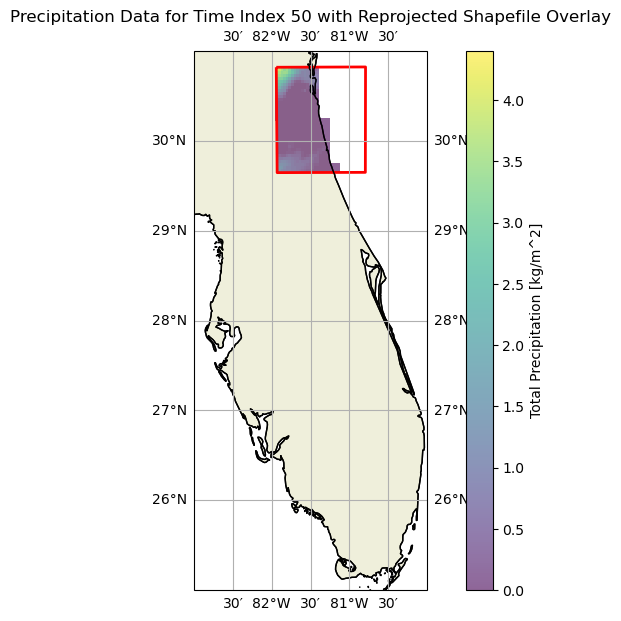

In [32]:

def plot_precipitation_with_shapefile_and_manual_extents(nc_file_path, shp_file_path, time_index=0):
    # Load the NetCDF file
    ds = xr.open_dataset(nc_file_path)
    
    # Select the precipitation data for a specific time step
    precip_data = ds['APCP_surface'].isel(time=time_index)
    
    # Load the shapefile using geopandas
    gdf = gpd.read_file(shp_file_path)
    
    # Reproject the shapefile to WGS 84 (if it's not already in that CRS)
    gdf = gdf.to_crs(epsg=4326)
    
    # Define the figure and axis with cartopy projection
    fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    
    # Plot the precipitation data
    precip_data.plot(x='longitude', y='latitude', transform=ccrs.PlateCarree(), 
                     cmap='viridis', add_colorbar=True, ax=ax, alpha=0.6)
    
    # Overlay the reprojected shapefile
    gdf.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2, transform=ccrs.PlateCarree())
    
    # Manually set the extents to zoom out further. Adjust these values based on your data's spatial range.
    # These values should cover both the precipitation data and the shapefile's extent.
    ax.set_extent([-83, -80, 25, 31], crs=ccrs.PlateCarree())
    
    
    # Add gridlines
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    
    plt.title(f'Precipitation Data for Time Index {time_index} with Reprojected Shapefile Overlay')
    plt.show()

# Path to your NetCDF file
nc_file_path = "Z:\JAX\AORC\combined_precipitation_data_clipped_new.nc4"

# Path to your shapefile
shp_file_path = "Z:/JAX/Domain_extent/domain_extent.shp"

plot_precipitation_with_shapefile_and_manual_extents(nc_file_path, shp_file_path, time_index=50)
